# Image Classifier

course: https://learn.deeplearning.ai/courses/pytorch-fundamentals/

lesson: https://learn.deeplearning.ai/specializations/pytorch-for-deep-learning-professional-certificate/lesson/shhwqe/image-classification---part-1

Dataset: MNIST

Purpose: Demonstrates a more mature training pipeline with everything learned so far in the course creating a PyTorch image classifier


In [2]:
# setup
# if running via local Python runtime instead of Colab
# addresses certificate error when retrieving from MNIST url, since local does not have SSL certificate correctly set up

import os, ssl
import certifi  # pip install certifi if needed

# Point SSL to certifi's CA bundle
os.environ["SSL_CERT_FILE"] = certifi.where()

# Make default HTTPS context use this cert bundle
ssl._create_default_https_context = ssl.create_default_context

In [3]:
# imports

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as torchvision_transforms

In [4]:
# Data Loading & Pre-processing

# pre-processing: initialize functions to transform data
mnist_dataset_mean = 0.1307 # value provided by course
mnist_dataset_std = 0.3081  # value provided by course
transform = torchvision_transforms.Compose([
    torchvision_transforms.ToTensor(),  # converts data to tensor
    torchvision_transforms.Normalize((mnist_dataset_mean,), (mnist_dataset_std,))
])

# load dataset: MNIST 
dataset_file_path = './data'    # if running via Colab, will be stored there
train_dataset = torchvision.datasets.MNIST(
    root=dataset_file_path,
    train=True, # retrieves 60,000 MNIST training images
    download=True,
    transform=transform
)
test_dataset = torchvision.datasets.MNIST(
    root=dataset_file_path,
    train=False, # retrieves 10,000 MNIST test images
    download=True,
    transform=transform
)

# create data loaders to segment datasets into batches
train_dataset_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True    # shuffles dataset for each epoch, since dataset may be sorted which would bias training through unintended patterns (e.g., all 0 digits in a batch since they are at top of dataset)
)
test_dataset_loader = DataLoader(
    test_dataset,
    batch_size=1000,    # okay to have larger batch sizes since no need to calculate gradients, which may overwhelm memory
    shuffle=False   # doesn't matter if data is sorted since just testing the trained model, not worried about biasing it
)

In [ ]:
# Data: Analyze data

# for my own understanding
input_image_tensor, target_label = train_dataset[0]    # first sample
input_image_tensor.shape   # out: [1, 28, 28]  => 3 features (grayscale, height, width)

torch.Size([1, 28, 28])

In [6]:
# Training: Build Model

# create neural network for MNIST classifier
class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten() # flatten 2D images into a vector for linear nn
        self.layers = nn.Sequential(
            nn.Linear(784, 128),    # each image is 28x28 pixels, so flattened vector would be 784 for linear layer
            nn.ReLU(),
            nn.Linear(128, 10)  # output is 10 digits
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers(x)
        return x

In [7]:
# Training: Initialize training objects

# GPU acceleration if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: { device }')

# Initialize model
model = MNISTClassifier().to(device)    # move to device

# Initialize loss function and optimizer
loss_function = nn.CrossEntropyLoss()   # loss function for classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer


Using device: cpu


In [8]:
# Training: Define training function

# define training function at epoch level for all batches
def train_epoch(
    model,
    train_dataset_loader,
    loss_function,
    optimizer,
    device
):
    
    # training mode for model
    model.train()   
    
    # initialize variables: tracking progress
    running_loss = 0.0  
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_dataset_loader):
        inputs, targets = inputs.to(device), targets.to(device)   # move data to device

        optimizer.zero_grad()   # reset gradients for batch cycle
        output = model(inputs)
        loss = loss_function(output, targets)
        loss.backward()
        optimizer.step()

        # Track progress
        running_loss += loss.item()
        _, predicted = output.max(1)    # gets output label (e.g., digit) with highest probability of being correct (highest confidence score, lowest loss)

        correct += predicted.eq(targets).sum().item()    # add up all correct outputs
        total += targets.size(0) # add number of samples in batch to total

        # Print progress
        PROGRESS_EVERY_N_BATCH = 100
        if batch_idx % PROGRESS_EVERY_N_BATCH == 0 and batch_idx > 0:
            avg_loss = running_loss / 100
            accuracy = 100. * correct / total
            print(f'[{batch_idx * 64}/{ 60000 }]'    # batch size per n batches out of total training dataset samples
                  f' '
                  f'Loss: {avg_loss:.3f} | Accuracy: {accuracy:.1f}%')
            
            running_loss = 0.0  # resets running loss after every n batches

In [9]:
# Training & Evaluation: Define evaluation function

def evaluate(
        model,
        test_dataset_loader,
        device
):
    
    model.eval()    # set model to evaluation mode
    
    # initialize variables: tracking progress
    correct = 0
    total = 0

    with torch.no_grad():       # no gradient descent since in eval mode, will speed things up
        for inputs, targets in test_dataset_loader:
            
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)

            # Retrieve evaluation variables for accuracy score
            _, predicted = outputs.max(1)
            total += targets.size(0)     # add size of batch to total
            correct += predicted.eq(targets).sum().item()

    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.1f}%')
    return accuracy



In [10]:
# Training: Training loop
num_epochs = 10
for epoch in range(num_epochs):
    print(f'Epoch: { epoch + 1 }')
    train_epoch(
        model,
        train_dataset_loader,
        loss_function,
        optimizer,
        device
    )
    accuracy = evaluate(
        model,
        test_dataset_loader,
        device
    )

Epoch: 1
[6400/60000] Loss: 0.635 | Accuracy: 81.5%
[12800/60000] Loss: 0.343 | Accuracy: 85.7%
[19200/60000] Loss: 0.255 | Accuracy: 87.9%
[25600/60000] Loss: 0.235 | Accuracy: 89.2%
[32000/60000] Loss: 0.235 | Accuracy: 90.0%
[38400/60000] Loss: 0.184 | Accuracy: 90.8%
[44800/60000] Loss: 0.169 | Accuracy: 91.4%
[51200/60000] Loss: 0.167 | Accuracy: 91.9%
[57600/60000] Loss: 0.151 | Accuracy: 92.3%
Test Accuracy: 95.8%
Epoch: 2
[6400/60000] Loss: 0.134 | Accuracy: 96.2%
[12800/60000] Loss: 0.109 | Accuracy: 96.6%
[19200/60000] Loss: 0.105 | Accuracy: 96.7%
[25600/60000] Loss: 0.122 | Accuracy: 96.6%
[32000/60000] Loss: 0.113 | Accuracy: 96.6%
[38400/60000] Loss: 0.120 | Accuracy: 96.5%
[44800/60000] Loss: 0.106 | Accuracy: 96.6%
[51200/60000] Loss: 0.107 | Accuracy: 96.6%
[57600/60000] Loss: 0.103 | Accuracy: 96.7%
Test Accuracy: 97.1%
Epoch: 3
[6400/60000] Loss: 0.078 | Accuracy: 97.7%
[12800/60000] Loss: 0.076 | Accuracy: 97.7%
[19200/60000] Loss: 0.077 | Accuracy: 97.7%
[25600/600

target label: 1
predicted_outputs: tensor([[-11.2152,   7.5163,  -4.7328, -10.3949,  -5.9403,  -6.5737,  -3.2017,
          -4.5079,  -2.5509, -10.8662]])
predicted label: 1


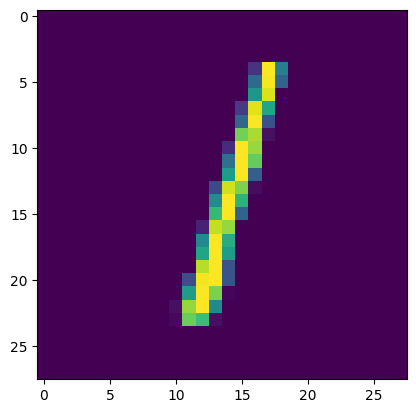

In [38]:
# Inference

# get input data
input_image_tensor, target_label = test_dataset[2]
# print(input_image_tensor)
print(f'target label: {target_label}')

# define inference function
def inference_digit(input_image_tensor):
    input_image_tensor = input_image_tensor.unsqueeze(0)  # since models expect batch, add dimension at index 0 for batch from [1,28,28] to [1,1,28,28]

    model.eval()
    with torch.no_grad():
        predicted_outputs = model(input_image_tensor)  # vector of confidence scores for all digit labels 0-9
        print(f'predicted_outputs: {predicted_outputs}')
        confidence_scores, predicted_label_tensor = predicted_outputs.max(1)
        predicted_label = predicted_label_tensor.item()
        # print(f'predicted_output {predicted_outputs}')    

    print(f'predicted label: {predicted_label}')
    return predicted_label
    


# run inference
inference_digit(input_image_tensor)

# visualize image
import matplotlib.pyplot as plt
plt.imshow(input_image_tensor.squeeze())   # reduce image back to three feature dimensions by removing batch dimension at index 0
plt.show()


In [ ]:
# Inference: Own handwritten digit


from PIL import Image

# load data
# make sure image is pixel size 28x28
handwritten_digit_image_path = 'data/custom/handwritten-digit-a.jpeg'   
img_object = Image.open(handwritten_digit_image_path).convert("L")    # converts image to grayscale (convert L)
# print(img_object)

# wrangle data
img_tensor = transform(img_object)          # data processing: convert into tensor and normalize 
# img_tensor = img_tensor.unsqueeze(0)        # add batch dimension
# print(img_tensor.shape)   # make sure image is pixel size 28x28 for correct shape => (1, 1, 28, 28)

# inference
inference_digit(img_tensor)

torch.Size([1, 28, 28])
predicted_outputs: tensor([[ -8.1590,  12.0817,  -9.0322,   1.2620, -15.7547,  -6.3961, -25.3064,
          -0.4236, -29.9919, -43.0300]])
predicted label: 1


1